In [11]:
import glob
import os

In [ ]:
# !pip install --upgrade -q git+https://github.com/keras-team/keras-cv

## Reference List

https://developer.nvidia.com/blog/fast-track-your-production-ai-with-pre-trained-models-and-tao-toolkit-3-0/
https://keras.io/examples/timeseries/timeseries_traffic_forecasting/
https://keras.io/guides/keras_cv/object_detection_keras_cv/

## GPU Checks
https://stackoverflow.com/questions/44544766/how-do-i-check-if-keras-is-using-gpu-version-of-tensorflow#44547144

In [1]:
import tensorflow as tf
print(tf.__version__)
tf.config.list_physical_devices('GPU')

2023-11-13 18:37:31.342365: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 18:37:32.213039: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/matt/miniconda3/envs/robots/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.13.0


2023-11-13 18:37:33.207474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 18:37:33.331122: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 18:37:33.331614: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Previous TensorFlow Install Guide
https://www.tensorflow.org/install/pip

https://keras.io/examples/vision/yolov8/

In [39]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

## Hyper Parameters

In [36]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0

In [ ]:
# !pip install roboflow

In [ ]:
# from roboflow import Roboflow
# rf = Roboflow(api_key="CfThL4bE8Z")
# project = rf.workspace("roboflow-gw7yv").project("self-driving-car")
# dataset = project.version(3).download("yolov8")

## Get Input Images and Annotations for the Yolo8 Model

In [13]:
class_ids = [
    "car",
    "pedestrian",
    "trafficLight",
    "biker",
    "truck",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "export/images/" #"/kaggle/input/dataset/data/images/"
path_annot = "export/labels/" #"/kaggle/input/dataset/data/annotations/"

# Get all XML file paths in path_annot and sort them
txt_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".txt")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)


In [14]:
label_files = glob.glob(f"{path_annot}*")
print(len(label_files))
label_files[:5]

29800


['export/labels/1478896928938416423_jpg.rf.kYj91j6BMt3KIYihOFLT.txt',
 'export/labels/1478900095024715037_jpg.rf.bf962ff644f95d0c82417d01eceecb86.txt',
 'export/labels/1478899896786707985_jpg.rf.RkD49wNL5ucdyWvu3aqY.txt',
 'export/labels/1478020604203617302_jpg.rf.ed3d14d0eff881495e9d584862382013.txt',
 'export/labels/1478896849527318206_jpg.rf.3e946a060fbf6c6b9bc5d1b288026436.txt']

In [16]:
print(f"Number Annotated (xml) files: {len(txt_files):,}")
print(f"Number of Image (jpg) files: {len(jpg_files):,}")

Number Annotated (xml) files: 29,800
Number of Image (jpg) files: 29,800


In [21]:
jpg_files[:5]

['export/images/1478019952686311006_jpg.rf.54e2d12dbabc46be3c78995b6eaf3fee.jpg',
 'export/images/1478019952686311006_jpg.rf.JLSB3LP2Q4RuGHYKqfF6.jpg',
 'export/images/1478019953180167674_jpg.rf.8a816c9d7e9b423a63ed6ecd4a663e47.jpg',
 'export/images/1478019953180167674_jpg.rf.azslsZnM8FLQPu3QWLTl.jpg',
 'export/images/1478019953689774621_jpg.rf.2e4b7ae29c3379da1282e85cff4c1745.jpg']

In [24]:
import numpy as np
import re

In [28]:
#Finding a Files Pair....
txt_file = np.random.choice(txt_files)
jpg_pair = txt_file.replace(".txt",".jpg").replace('/labels/','/images/')
[f for f in jpg_files if f == jpg_pair]

['export/images/1478899691122801774_jpg.rf.721a2baae483c8999be1c2303d3bfc55.jpg']

## Preview an Annotation File

> My Download from RoboFlow: https://public.roboflow.com/object-detection/self-driving-car/3#
produced txt files instead of XML files. Adapting code accordingly.

In [31]:
txt_file = txt_files[0]
with open(txt_file, "r") as f:
    for line in f.readlines():
        class_, xmin, xmax, ymin, ymax = [float(x) for x in line.split()]
        print(class_, xmin, xmax, ymin, ymax)

10.0 0.43359375 0.48828125 0.0166015625 0.0283203125
1.0 0.458984375 0.494140625 0.0244140625 0.0263671875
1.0 0.5087890625 0.4970703125 0.0283203125 0.0380859375
2.0 0.9287109375 0.5107421875 0.0361328125 0.21875


**Comment:**
> Appears to be of the form:  
category, bounding box x?min x?max y?min y?max

In [32]:
def parse_annotation(txt_file):
    jpg_pair = txt_file.replace(".txt",".jpg").replace('/labels/','/images/')
    classes = []
    boxes = []
    with open(txt_file, "r") as f:
        for line in f.readlines():
            cls, xmin, xmax, ymin, ymax = [float(x) for x in line.split()]
            cls = int(cls)
            classes.append(cls)
            boxes.append([xmin, ymin, xmax, ymax])
    return jpg_pair, boxes, classes

In [33]:
# def parse_annotation(xml_file):
#     tree = ET.parse(xml_file)
#     root = tree.getroot()

#     image_name = root.find("filename").text
#     image_path = os.path.join(path_images, image_name)

#     boxes = []
#     classes = []
#     for obj in root.iter("object"):
#         cls = obj.find("name").text
#         classes.append(cls)

#         bbox = obj.find("bndbox")
#         xmin = float(bbox.find("xmin").text)
#         ymin = float(bbox.find("ymin").text)
#         xmax = float(bbox.find("xmax").text)
#         ymax = float(bbox.find("ymax").text)
#         boxes.append([xmin, ymin, xmax, ymax])

#     class_ids = [
#         list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
#         for cls in classes
#     ]
#     return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for txt_file in tqdm(txt_files):
    image_path, boxes, class_ids = parse_annotation(txt_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)
print(f"Number of image paths: {len(image_paths):,}")

  0%|          | 0/29800 [00:00<?, ?it/s]

Number of image paths: 29,800


Here we are using tf.ragged.constant to create ragged tensors from the bbox and classes lists. A ragged tensor is a type of tensor that can handle varying lengths of data along one or more dimensions. This is useful when dealing with data that has variable-length sequences, such as text or time series data.

```python
classes = [
    [8, 8, 8, 8, 8],      # 5 classes
    [12, 14, 14, 14],     # 4 classes
    [1],                  # 1 class
    [7, 7],               # 2 classes
 ...]

bbox = [
    [[199.0, 19.0, 390.0, 401.0],
    [217.0, 15.0, 270.0, 157.0],
    [393.0, 18.0, 432.0, 162.0],
    [1.0, 15.0, 226.0, 276.0],
    [19.0, 95.0, 458.0, 443.0]],     #image 1 has 4 objects
    [[52.0, 117.0, 109.0, 177.0]],   #image 2 has 1 object
    [[88.0, 87.0, 235.0, 322.0],
    [113.0, 117.0, 218.0, 471.0]],   #image 3 has 2 objects
 ...]
```

In this case, the bbox and classes lists have different lengths for each image, depending on the number of objects in the image and the corresponding bounding boxes and classes. To handle this variability, ragged tensors are used instead of regular tensors.

Later, these ragged tensors are used to create a tf.data.Dataset using the from_tensor_slices method. This method creates a dataset from the input tensors by slicing them along the first dimension. By using ragged tensors, the dataset can handle varying lengths of data for each image and provide a flexible input pipeline for further processing.

In [34]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))


2023-11-20 20:47:19.429457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 20:47:19.430048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 20:47:19.430370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Split INto Training and Validation Sets

In [37]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [ ]:
keras.layers.

In [40]:
bounding_boxes = {
    # num_boxes may be a Ragged dimension
    'boxes': Tensor(shape=[batch, num_boxes, 4]),
    'classes': Tensor(shape=[batch, num_boxes])
}

NameError: name 'Tensor' is not defined

In [41]:
{"images": images, "bounding_boxes": bounding_boxes}

NameError: name 'images' is not defined

In [42]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


### Keras Bounding Box Formats:

https://keras.io/api/keras_cv/bounding_box/formats/

In [43]:
boxes = keras_cv.bounding_box.convert_format(
        bounding_box,
        images=image,
        source="xyxy",  # Original Format
        target="xywh",  # Target Format (to which we want to convert)
    )

NameError: name 'image' is not defined

## Data Augmentation

Data Augmentation

One of the most challenging tasks when constructing object detection pipelines is data augmentation. It involves applying various transformations to the input images to increase the diversity of the training data and improve the model's ability to generalize. However, when working with object detection tasks, it becomes even more complex as these transformations need to be aware of the underlying bounding boxes and update them accordingly.

KerasCV provides native support for bounding box augmentation. KerasCV offers an extensive collection of data augmentation layers specifically designed to handle bounding boxes. These layers intelligently adjust the bounding box coordinates as the image is transformed, ensuring that the bounding boxes remain accurate and aligned with the augmented images.

By leveraging KerasCV's capabilities, developers can conveniently integrate bounding box-friendly data augmentation into their object detection pipelines. By performing on-the-fly augmentation within a tf.data pipeline, the process becomes seamless and efficient, enabling better training and more accurate object detection results.

In [44]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)


In [45]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [46]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

2023-11-20 20:59:06.812074: I tensorflow/core/framework/local_rendezvous.cc:409] Local rendezvous send item cancelled. Key hash: 13314386299108000305


StopIteration: 

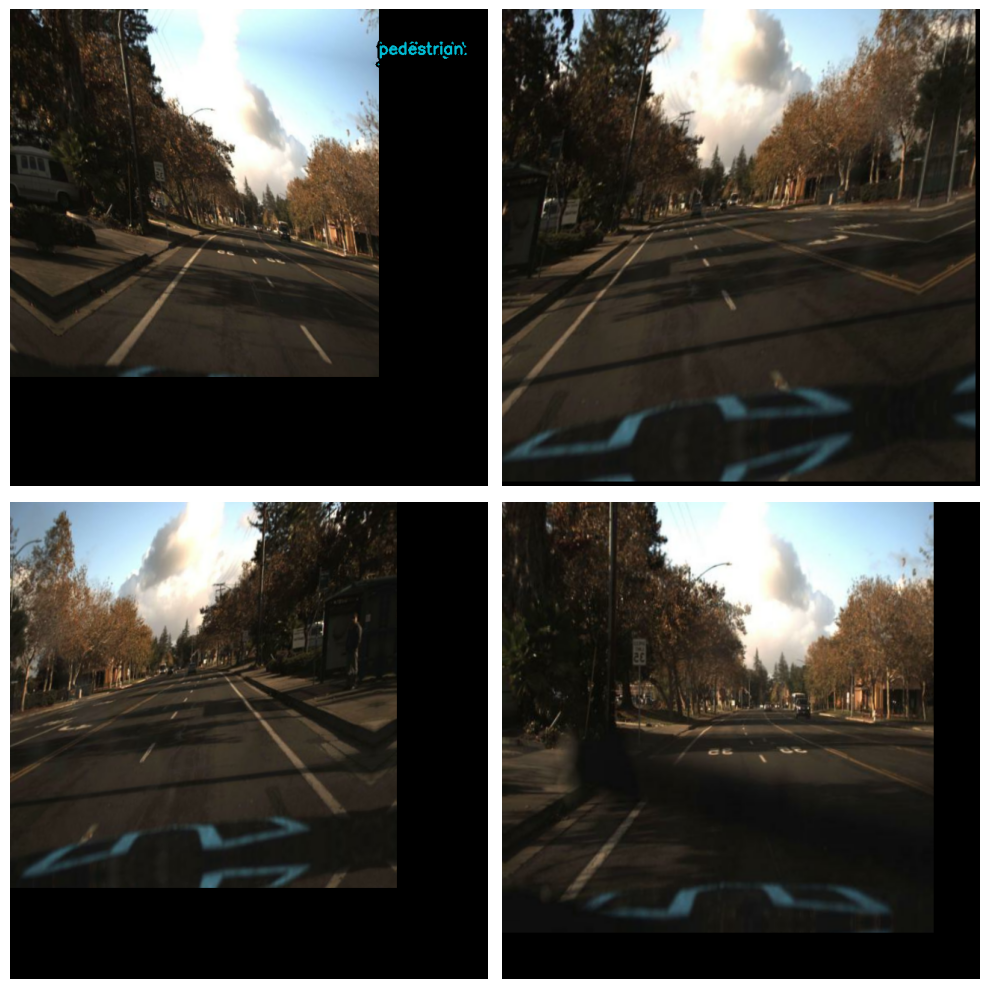

In [47]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [48]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)


## More on YoloV8 From RoboFlow: https://blog.roboflow.com/whats-new-in-yolov8/

In [49]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

20596968/20596968 [==============================] - 1s 0us/step


In [50]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

## Compile

In [51]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

## COCO Metric Callback

In [53]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs


## Train!

In [54]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)

Epoch 1/3


2023-11-20 21:03:03.025772: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-20 21:03:09.176494: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fcfef4f9eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-20 21:03:09.176515: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2023-11-20 21:03:09.214538: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-20 21:03:09.454827: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7450/7450 [==============================] - ETA: 0s - loss: 49.6236 - box_loss: 0.0000e+00 - class_loss: 49.6236

2023-11-20 21:36:21.528143: W tensorflow/core/framework/op_kernel.cc:1816] INVALID_ARGUMENT: ValueError: Attempt to convert a value (DictWrapper({'AP': 0, 'AP50': 0, 'AP75': 0, 'APs': 0, 'APm': 0, 'APl': 0, 'ARmax1': 0, 'ARmax10': 0, 'ARmax100': 0, 'ARs': 0, 'ARm': 0, 'ARl': 0})) with an unsupported type (<class 'tensorflow.python.trackable.data_structures._DictWrapper'>) to a Tensor.
Traceback (most recent call last):

  File "/home/matt/miniconda3/envs/robots/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)

  File "/home/matt/miniconda3/envs/robots/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)

  File "/home/matt/miniconda3/envs/robots/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 151, in _call
    ret = self._func(*args)

  File "/home/matt/miniconda3/envs/robots/lib/python3.9/site-packages/tensorflow/p

InvalidArgumentError: {{function_node __wrapped__EagerPyFunc_Tin_1_Tout_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} ValueError: Attempt to convert a value (DictWrapper({'AP': 0, 'AP50': 0, 'AP75': 0, 'APs': 0, 'APm': 0, 'APl': 0, 'ARmax1': 0, 'ARmax10': 0, 'ARmax100': 0, 'ARs': 0, 'ARm': 0, 'ARl': 0})) with an unsupported type (<class 'tensorflow.python.trackable.data_structures._DictWrapper'>) to a Tensor.
Traceback (most recent call last):

  File "/home/matt/miniconda3/envs/robots/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)

  File "/home/matt/miniconda3/envs/robots/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)

  File "/home/matt/miniconda3/envs/robots/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 151, in _call
    ret = self._func(*args)

  File "/home/matt/miniconda3/envs/robots/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/home/matt/miniconda3/envs/robots/lib/python3.9/site-packages/keras_cv/metrics/object_detection/box_coco_metrics.py", line 203, in result_on_host_cpu
    return tf.constant(obj_result(force), obj.dtype)

  File "/home/matt/miniconda3/envs/robots/lib/python3.9/site-packages/tensorflow/python/framework/constant_op.py", line 263, in constant
    return _constant_impl(value, dtype, shape, name, verify_shape=False,

  File "/home/matt/miniconda3/envs/robots/lib/python3.9/site-packages/tensorflow/python/framework/constant_op.py", line 275, in _constant_impl
    return _constant_eager_impl(ctx, value, dtype, shape, verify_shape)

  File "/home/matt/miniconda3/envs/robots/lib/python3.9/site-packages/tensorflow/python/framework/constant_op.py", line 285, in _constant_eager_impl
    t = convert_to_eager_tensor(value, ctx, dtype)

  File "/home/matt/miniconda3/envs/robots/lib/python3.9/site-packages/tensorflow/python/framework/constant_op.py", line 98, in convert_to_eager_tensor
    return ops.EagerTensor(value, ctx.device_name, dtype)

ValueError: Attempt to convert a value (DictWrapper({'AP': 0, 'AP50': 0, 'AP75': 0, 'APs': 0, 'APm': 0, 'APl': 0, 'ARmax1': 0, 'ARmax10': 0, 'ARmax100': 0, 'ARs': 0, 'ARm': 0, 'ARl': 0})) with an unsupported type (<class 'tensorflow.python.trackable.data_structures._DictWrapper'>) to a Tensor.

 [Op:EagerPyFunc] name: 

## Visualize!

Visualize Predictions

In [55]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")


StopIteration: 